### Import Library

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

### Load data

In [7]:

df_data = pd.read_csv('climate_data.csv')
df_province = pd.read_csv('province_detail.csv')
df_station = pd.read_csv('station_detail.csv')

In [8]:

df_combined = df_data.merge(df_station, on="station_id", how="inner")
df_combined = df_combined.merge(df_province, on="province_id", how="left")

df_combined = df_combined[['date', 'station_id', 'station_name', 'region_name', 'region_id', 'province_id', 'province_name', 'latitude', 'longitude', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg', 'ddd_car']]
              

### UNDERSTANDING

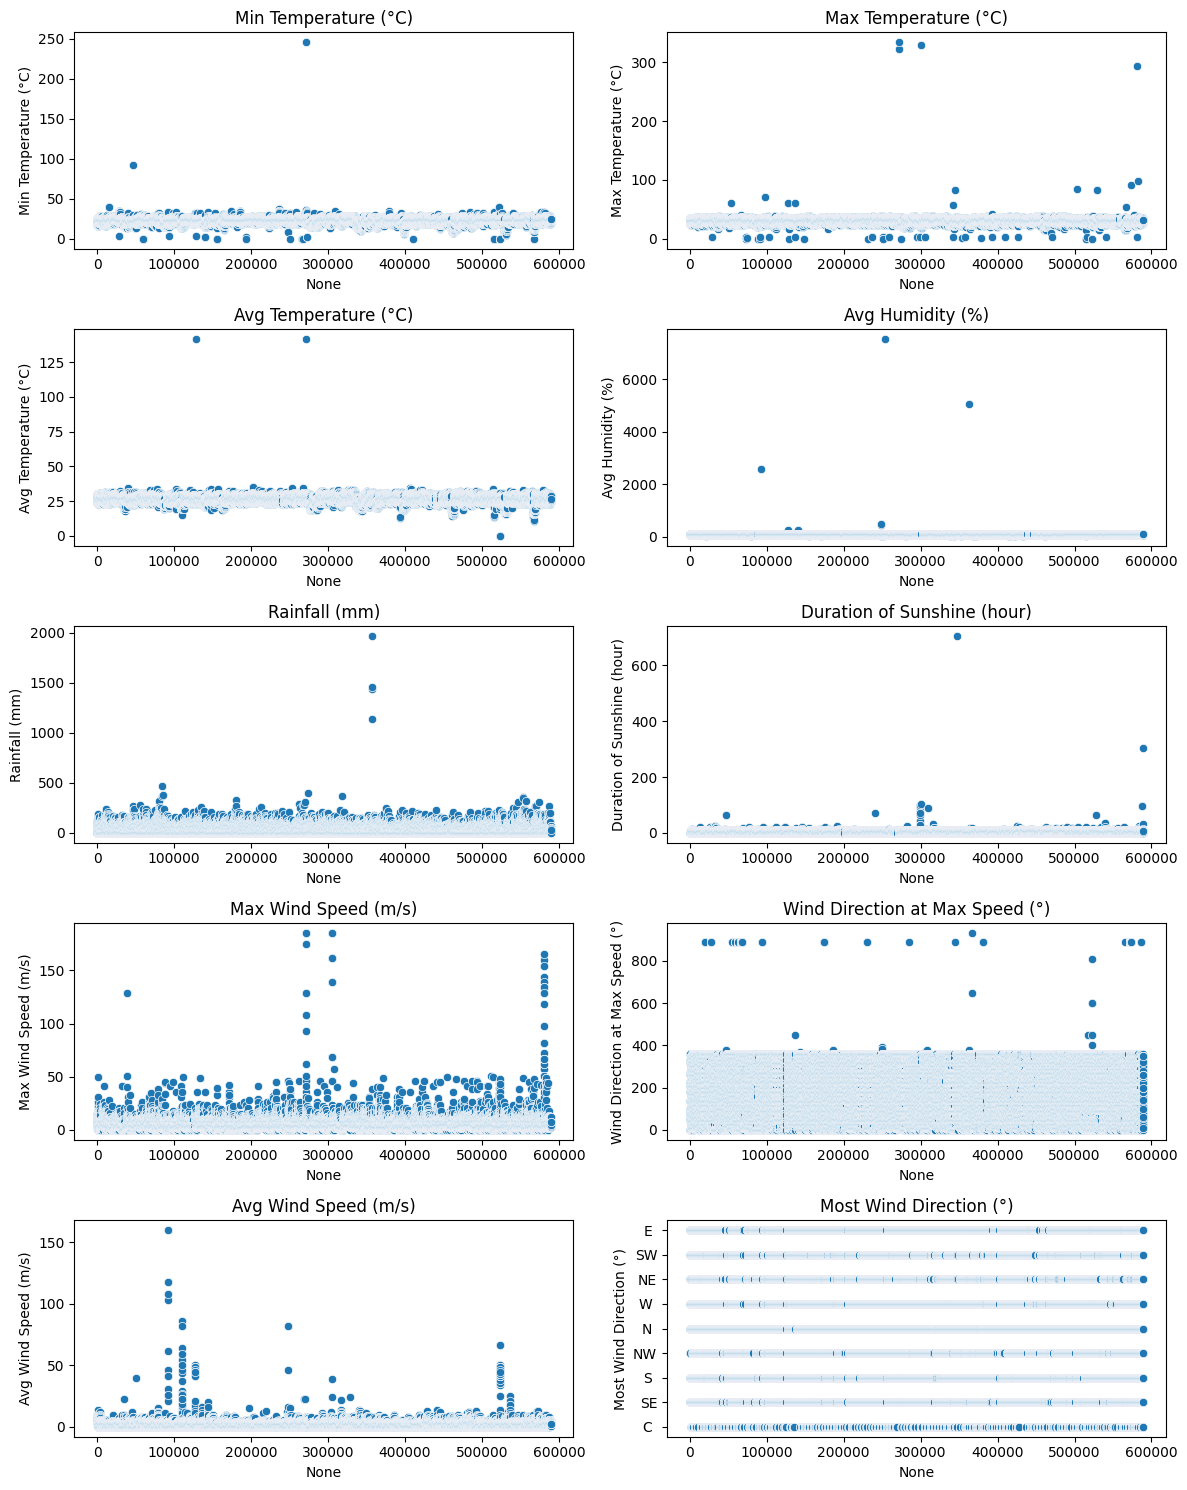

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_combined.rename(columns={
    'Tn': 'Min Temperature (°C)',
    'Tx': 'Max Temperature (°C)',
    'Tavg': 'Avg Temperature (°C)',
    'RH_avg': 'Avg Humidity (%)',
    'RR': 'Rainfall (mm)',
    'ss': 'Duration of Sunshine (hour)',
    'ff_x': 'Max Wind Speed (m/s)',
    'ddd_x': 'Wind Direction at Max Speed (°)',
    'ff_avg': 'Avg Wind Speed (m/s)',
    'ddd_car': 'Most Wind Direction (°)'
})

# Pilih fitur yang ingin dicek outlier
features = ['Min Temperature (°C)', 'Max Temperature (°C)', 'Avg Temperature (°C)',
            'Avg Humidity (%)', 'Rainfall (mm)', 'Duration of Sunshine (hour)',
            'Max Wind Speed (m/s)', 'Wind Direction at Max Speed (°)',
            'Avg Wind Speed (m/s)', 'Most Wind Direction (°)']

# Buat scatter plot masing-masing fitur terhadap indeks
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    sns.scatterplot(x=df_plot.index, y=df_plot[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

In [10]:

for col in df_data.select_dtypes(include=[int, float]).columns:
    max_value = df_combined[col].max()
    min_value = df_combined[col].min()
    print(f"🔹 {col}:")
    print(f"   - Max: {max_value}")
    print(f"   - Min: {min_value}")

🔹 Tn:
   - Max: 246.0
   - Min: 0.0
🔹 Tx:
   - Max: 334.0
   - Min: 0.0
🔹 Tavg:
   - Max: 141.6
   - Min: 0.0
🔹 RH_avg:
   - Max: 7520.0
   - Min: 24.0
🔹 RR:
   - Max: 1965.5
   - Min: -1.0
🔹 ss:
   - Max: 705.0
   - Min: 0.0
🔹 ff_x:
   - Max: 185.0
   - Min: 0.0
🔹 ddd_x:
   - Max: 931.0
   - Min: 0.0
🔹 ff_avg:
   - Max: 160.0
   - Min: 0.0
🔹 station_id:
   - Max: 97980
   - Min: 96001


In [11]:
# Featuring Engineering

# Suhu Minimum
df_combined.loc[df_combined['Tn'] > 25 , 'Tn'] = np.nan
df_combined.loc[df_combined['Tn'] < 9, 'Tn'] = np.nan

# Suhu Maksimal
df_combined.loc[df_combined['Tx'] < 25.01 , 'Tx'] = np.nan
df_combined.loc[df_combined['Tx'] > 42, 'Tx'] = np.nan

#Suhu Rata-Rata
df_combined.loc[df_combined['Tavg'] > 36 , 'Tavg'] = np.nan
df_combined.loc[df_combined['Tavg'] < 10 , 'Tavg'] = np.nan

# Kelembaban
df_combined.loc[df_combined['RH_avg'] > 100 , 'RH_avg'] = np.nan
df_combined.loc[df_combined['RH_avg'] <= 0, 'RH_avg'] = np.nan

# Durasi Cahaya Matahari
df_combined.loc[df_combined['ss'] > 24 , 'ss'] = np.nan
df_combined.loc[df_combined['ss'] <= 0 , 'ss'] = np.nan

# Wind Direction at Max Speed 

df_combined.loc[df_combined['ff_x'] <=0 , 'ff_x'] = np.nan
df_combined.loc[df_combined['ff_avg'] <=0 , 'ff_avg'] = np.nan

#'Avg Wind Speed 
df_combined.loc[df_combined['ddd_x'] < 0 , 'ddd_x'] = np.nan
df_combined.loc[df_combined['ddd_x'] > 360 , 'ddd_x'] = np.nan


# Most Wind Direction 
mapping = {
    'N': 0, 'NE': 45, 'E': 90, 'SE': 135, 'S': 180,
    'SW': 225, 'W': 270, 'NW': 315, 'C': -1
}
df_combined['ddd_car'] = df_combined['ddd_car'].str.strip().map(mapping)

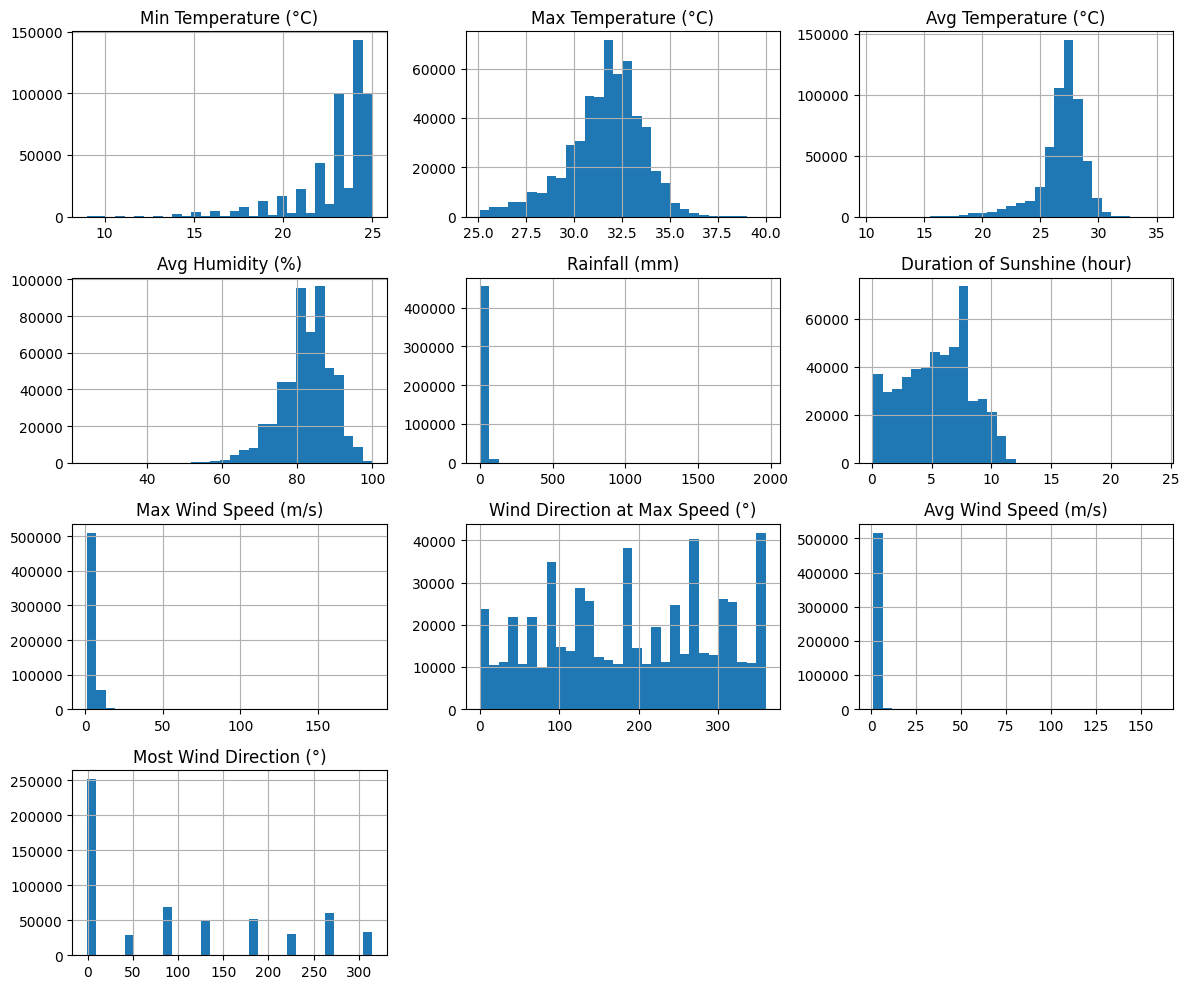

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah nama kolom untuk tampilan grafik
df_plot = df_combined.rename(columns={
    'Tn': 'Min Temperature (°C)',
    'Tx': 'Max Temperature (°C)',
    'Tavg': 'Avg Temperature (°C)',
    'RH_avg': 'Avg Humidity (%)',
    'RR': 'Rainfall (mm)',
    'ss': 'Duration of Sunshine (hour)',
    'ff_x': 'Max Wind Speed (m/s)',
    'ddd_x': 'Wind Direction at Max Speed (°)',
    'ff_avg': 'Avg Wind Speed (m/s)',
    'ddd_car': 'Most Wind Direction (°)'
})

# Histogram untuk distribusi masing-masing fitur
df_plot[['Min Temperature (°C)', 'Max Temperature (°C)', 'Avg Temperature (°C)',
         'Avg Humidity (%)', 'Rainfall (mm)', 'Duration of Sunshine (hour)',
         'Max Wind Speed (m/s)', 'Wind Direction at Max Speed (°)',
         'Avg Wind Speed (m/s)', 'Most Wind Direction (°)']].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()


In [13]:

for col in df_data.select_dtypes(include=[int, float]).columns:
    max_value = df_combined[col].max()
    min_value = df_combined[col].min()
    print(f"🔹 {col}:")
    print(f"   - Max: {max_value}")
    print(f"   - Min: {min_value}")

🔹 Tn:
   - Max: 25.0
   - Min: 9.0
🔹 Tx:
   - Max: 40.0
   - Min: 25.1
🔹 Tavg:
   - Max: 35.2
   - Min: 10.6
🔹 RH_avg:
   - Max: 100.0
   - Min: 24.0
🔹 RR:
   - Max: 1965.5
   - Min: -1.0
🔹 ss:
   - Max: 24.0
   - Min: 0.1
🔹 ff_x:
   - Max: 185.0
   - Min: 1.0
🔹 ddd_x:
   - Max: 360.0
   - Min: 0.0
🔹 ff_avg:
   - Max: 160.0
   - Min: 1.0
🔹 station_id:
   - Max: 97980
   - Min: 96001


### Featuring Engineering

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from joblib import dump
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

df_combined['Tavg_3days_avg'] = df_combined['Tavg'].rolling(window=3).mean()
df_combined['RH_avg_3days_avg'] = df_combined['RH_avg'].rolling(window=3).mean()
df_combined['ff_avg_3days_avg'] = df_combined['ff_avg'].rolling(window=3).mean()

df_combined['RR_tomorrow'] = df_combined['RR'].shift(-1)
df_combined['RR_yesterday'] = df_combined['RR'].shift(1)
df_combined['RR_3days_avg'] = df_combined['RR'].rolling(window=3).mean()
df_combined['Tavg_yesterday'] = df_combined['Tavg'].shift(1)
df_combined['RH_avg_yesterday'] = df_combined['RH_avg'].shift(1)
df_combined['ff_avg_yesterday'] = df_combined['ff_avg'].shift(1)
df_combined['ddd_x_yesterday'] = df_combined['ddd_x'].shift(1)

df_combined = df_combined.interpolate()

df_combined.fillna(method='bfill', inplace=True)

def categorize_weather(row):
    if row['RR_tomorrow'] > 2:  
        if row['RR_tomorrow'] > 15 or (row['RH_avg'] > 85 and row['ff_avg'] > 12):  
            return 'Hujan Lebat' 
        elif row['RR_tomorrow'] > 7 or row['RH_avg'] > 80:  
            return 'Hujan Lebat'  
        else:  
            return 'Hujan Ringan'  
    else:  
        if row['ss'] > 8 and row['ff_avg'] < 4 and row['Tavg'] > 24:  
            return 'Cerah'
        elif 4 <= row['ss'] <= 8 and row['ff_avg'] < 6:  
            return 'Cerah Berawan'
        elif row['RH_avg'] > 75 and row['ff_avg'] > 8:  
            return 'Mendung'
        else:  
            return 'Mendung'

df_combined['Weather_tomorrow'] = df_combined.apply(categorize_weather, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_12340\2581036665.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_combined = df_combined.interpolate()
C:\Users\USER\AppData\Local\Temp\ipykernel_12340\2581036665.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined.fillna(method='bfill', inplace=True)


### SPLIT DATA

In [15]:
features = ['RR', 'RR_yesterday', 'RR_3days_avg', 'Tavg', 'Tavg_yesterday',
            'RH_avg', 'RH_avg_yesterday', 'ff_avg', 'ff_avg_yesterday', 'ddd_x', 'ddd_x_yesterday', 'ss']
target = 'Weather_tomorrow'

X = df_combined[features]
y = df_combined[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### MODEL - EVALUASI

In [16]:
from joblib import dump
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LightGBM model
lgbm_clf = LGBMClassifier(
    n_estimators=2000,  
    learning_rate=0.05,  
    num_leaves=512,  
    max_depth=14,  
    min_child_samples=100,  
    subsample=0.9,  
    colsample_bytree=0.9,  
    reg_alpha=0.2,  
    reg_lambda=0.2,  
    random_state=42
)

lgbm_clf.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_clf.predict(X_test_scaled)

# Save model and scaler
dump(lgbm_clf, "model_fixbgtoke.pkl")
dump(scaler, "scaler_fixbgtoke.pkl")

# Evaluation
print("\nOptimized LightGBM Results:")
print(classification_report(y_test, lgbm_pred))
print(f"Accuracy: {accuracy_score(y_test, lgbm_pred)}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3015
[LightGBM] [Info] Number of data points in the train set: 471412, number of used features: 12
[LightGBM] [Info] Start training from score -2.462313
[LightGBM] [Info] Start training from score -1.316162
[LightGBM] [Info] Start training from score -0.843404
[LightGBM] [Info] Start training from score -3.182092
[LightGBM] [Info] Start training from score -1.743783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g